<a href="https://colab.research.google.com/github/Fabiancaru/Advanced_Methods_Data_Analysis_II/blob/main/transferencia_aprendizaje_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRANSFERENCIA DE APRENDIZAJE CON VGG-16

## 1 - El problema a resolver

Queremos usar el set [*tf_flowers*](https://knowyourdata-tfds.withgoogle.com/#tab=STATS&dataset=tf_flowers), con 3670 imágenes y 5 categorías, e implementar una Red Convolucional para su clasificación:

![ejemplo dataset](https://storage.googleapis.com/tfds-data/visualization/fig/tf_flowers-3.0.1.png)

## 2 - Alternativas de solución

1. Crear y entrenar "desde cero" una Red Convolucional
2. **Aprovechar modelos pre-entrenados (como VGG-16), con un buen desempeño, para resolver esta tarea**

## 3 - La transferencia de aprendizaje


![](https://drive.google.com/uc?export=view&id=1LlcOYZ7bgCgaVMgiRYtuvI1b8FA6tZlE)

## 4 - Descarga del set de datos, creación de los sets de entrenamiento y prueba y exploración



In [1]:
# El dataset puede ser fácilmente descargado usando TensorFlow
# (200 MB aproximadamente)

import tensorflow_datasets as tfds

(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Entrenamiento: 70%, prueba: 30%
    batch_size=-1,
    as_supervised=True,  # Incluir categoría de cada imagen
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [2]:
# Cada arreglo es una variable tipo "EagerTensor". Lo convertiremos a Numpy
type(train_ds)

x_train = train_ds.numpy()
y_train = train_labels.numpy()
x_test = test_ds.numpy()
y_test = test_labels.numpy()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# Y eliminar los tensores iniciales para liberar espacio en memoria
del train_ds
del train_labels
del test_ds
del test_labels

(2569, 442, 1024, 3)
(2569,)
(1101, 442, 1024, 3)
(1101,)


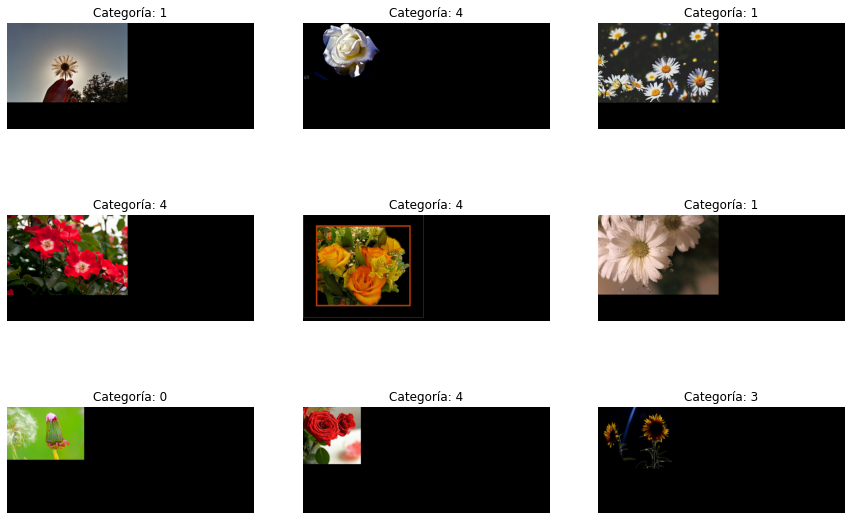

In [3]:
# Mostrar algunas imágenes y sus categorías
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.choice(2569,9)
fig, axes = plt.subplots(3,3,figsize=(15,10))
for i, axis in enumerate(axes.flat):
  axis.imshow(x_train[idx[i],:,:,:]);
  axis.axis('off')

  titulo = f'Categoría: {y_train[idx[i]]}'
  axis.set_title(titulo)

# Categorías
# 0 - Diente de león
# 1 - Margaritas
# 2 - Tulipanes
# 3 - Girasoles
# 4 - Rosas


## 5 - Pre-procesamiento del set de datos

In [4]:
# Reajustar el tamaño de las imágenes a 224x224x3
# y eliminar las originales para optimizar uso de la RAM

import tensorflow as tf
x_train_r = tf.image.resize(x_train, (224, 224)).numpy()
x_test_r = tf.image.resize(x_test, (224, 224)).numpy()

del x_train
del x_test

print(x_train_r.shape)
print(x_test_r.shape)

(2569, 224, 224, 3)
(1101, 224, 224, 3)


In [5]:
# Representar categorías en formato one-hot
from tensorflow.keras.utils import to_categorical

y_train_oh = to_categorical(y_train, num_classes=5)
y_test_oh = to_categorical(y_test, num_classes=5)

print(y_train_oh.shape)
print(y_test_oh.shape)

(2569, 5)
(1101, 5)


Adicionalmente las imágenes deben ser [pre-procesadas](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input#returns) de igual forma a como lo hacen los autores de VGG-16 con las imágenes de ImageNet:

In [6]:
from tensorflow.keras.applications.vgg16 import preprocess_input

x_train_r = preprocess_input(x_train_r)
x_test_r = preprocess_input(x_test_r)

## 6 - Preparación del modelo pre-entrenado (VGG-16)

Usando Keras, tomaremos el modelo VGG-16 pre-entrenado pero eliminaremos las capas *fully connected* (se preservarán únicamente las capas de extracción de características).

Además lo "congelaremos" para que no puedan ser entrenadas estas capas:

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg_pretrained = VGG16(weights="imagenet", include_top=False,
                       input_shape=x_train_r.shape[1:4])
vgg_pretrained.trainable = False


58900480/58889256 [==============================] - 2s 0us/step


In [8]:
vgg_pretrained.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 7 - Agregar capas "fully connected" al modelo pre-entrenado

Flatten -> F.C. 50 neuronas -> F.C. 25 neuronas -> Salida 5 neuronas

In [9]:
from tensorflow.keras import layers, models

SEED = 27
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Crear las capas individuales
flatten = layers.Flatten(name='Flatten')
fc1 = layers.Dense(50, activation='relu', name='FC1')
fc2 = layers.Dense(25, activation='relu', name='FC2')
salida = layers.Dense(5, activation='softmax', name='output')

# Y añadirlas al modelo pre-entrenado
modelo = models.Sequential([
                            vgg_pretrained,
                            flatten,
                            fc1,
                            fc2,
                            salida
])

modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 25088)             0         
                                                                 
 FC1 (Dense)                 (None, 50)                1254450   
                                                                 
 FC2 (Dense)                 (None, 25)                1275      
                                                                 
 output (Dense)              (None, 5)                 130       
                                                                 
Total params: 15,970,543
Trainable params: 1,255,855
Non-trainable params: 14,714,688
_________________________________________________________________


## 8 - Entrenamiento del modelo



Escogemos la GPU como método de entrenamiento y usaremos:

- 10 iteraciones
- Tamaño de lote de 32
- Y *Adam* como método de optimización

In [10]:
modelo.compile(optimizer='adam', loss='categorical_crossentropy', 
               metrics=['accuracy'])

historia = modelo.fit(x_train_r, y_train_oh,
                      epochs=10,
                      batch_size=32,
                      validation_data=(x_test_r,y_test_oh))

Epoch 1/10
81/81 [==============================] - 33s 252ms/step - loss: 1.5110 - accuracy: 0.5356 - val_loss: 0.7369 - val_accuracy: 0.7457
Epoch 2/10
81/81 [==============================] - 17s 210ms/step - loss: 0.7568 - accuracy: 0.7256 - val_loss: 0.5007 - val_accuracy: 0.8238
Epoch 3/10
81/81 [==============================] - 17s 214ms/step - loss: 0.5056 - accuracy: 0.8194 - val_loss: 0.4076 - val_accuracy: 0.8665
Epoch 4/10
81/81 [==============================] - 18s 218ms/step - loss: 0.3819 - accuracy: 0.8641 - val_loss: 0.3298 - val_accuracy: 0.8965
Epoch 5/10
81/81 [==============================] - 18s 223ms/step - loss: 0.2775 - accuracy: 0.9070 - val_loss: 0.1778 - val_accuracy: 0.9455
Epoch 6/10
81/81 [==============================] - 18s 218ms/step - loss: 0.1986 - accuracy: 0.9338 - val_loss: 0.1678 - val_accuracy: 0.9564
Epoch 7/10
81/81 [==============================] - 17s 216ms/step - loss: 0.1480 - accuracy: 0.9556 - val_loss: 0.1036 - val_accuracy: 0.9728

## 9 - Resultados del entrenamiento

In [11]:
import matplotlib.pyplot as plt

def graficar(historia):
  plt.figure(figsize=(15,5))

  loss = historia.history['loss']
  accuracy = historia.history['accuracy']
  test_loss = historia.history['val_loss']
  test_accuracy = historia.history['val_accuracy']
  epochs = historia.epoch

  plt.subplot(121)
  plt.plot(epochs,loss,label='train_loss')
  plt.plot(epochs,test_loss,'b--',label='test_loss')
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs,accuracy,label='train_acc')
  plt.plot(epochs,test_accuracy,'b--',label='test_acc')
  plt.legend()

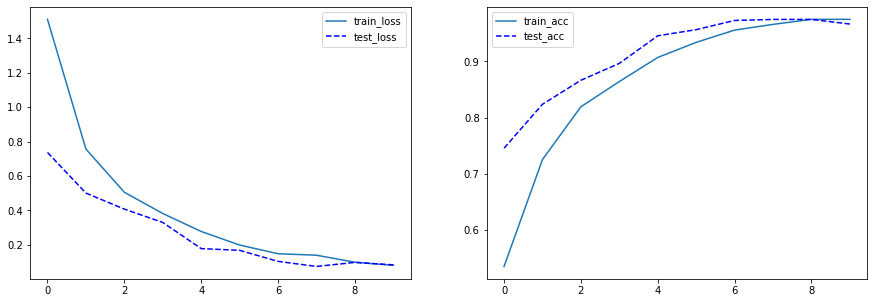

In [12]:
graficar(historia)

## Algunos resultados de la clasificación

In [13]:
# Realizar la predicción sobre el set de prueba
probabilidades = modelo.predict(x_test_r)
preds = np.argmax(probabilidades,axis=1)

In [14]:
# Y extraer algunas imágenes y sus categorías (reales y predichas)
N_imgs = preds.size    # Número de imágenes en el set de prueba
idx = np.random.choice(N_imgs,10)

print('Categoría real / Predicción:')
for i in idx:
  print(f'    Imagen {i}: {y_test[i]} / {preds[i]}')

Categoría real / Predicción:
    Imagen 1043: 0 / 0
    Imagen 543: 2 / 2
    Imagen 752: 3 / 3
    Imagen 1048: 3 / 3
    Imagen 141: 1 / 1
    Imagen 881: 2 / 2
    Imagen 1026: 3 / 3
    Imagen 639: 2 / 2
    Imagen 703: 3 / 3
    Imagen 225: 0 / 0
